# `Example` Hidden Markov Model of Investor Sentiment
Hidden Markov models (HMMs) are Markov models with unobservable states $s\in\mathcal{S}$ but observable outcomes $o\in\mathcal{O}$. Each hidden state in an HMM emits an observable single $o_{t}$ at time $t$, with the emission probability:

$$
\begin{equation*}
P(Y = o_{t}\,|\,X = s_{t})
\end{equation*}
$$

where $Y$ is the observable outcome and $X$ is the hidden state. Similar to the transition probability, the emission probability must sum to unity:

$$
\begin{equation*}
\sum_{o\in\mathcal{O}} P(Y = o\,|\,X = s) = 1\qquad\forall{s\in\mathcal{S}}
\end{equation*}
$$

The emission probability plays a crucial role in HMMs, as it is used to calculate the likelihood of a sequence of observed symbols, 
given the current state of the hidden Markov chain. To explore these ideas, let's construct a three-state, three-output Hidden Markov Model (HMM):

<div>
    <center>
        <img src="figs/Fig-ThreeState-ThreeAction-Markov.png" width="480"/>
    </center>
</div>

that models an investor’s sentiment and reaction to a news feed. Let the states $\mathcal{S} = \left\{1,2,3\right\}$ correspond to `{optimistic, neutral, pessimistic}`. Each state $s_{j}$ in the HMM emits a unique action $a_{j}$, where $a_{1}$ corresponds to a `buy` action, $a_{2}$ corresponds to a `null` action, i.e., do nothing and $a_{3}$ corresponds to a `sell` action. The probability that the state transitions between state $s_{i}$ and $s_{j}$ in the next step is described by $p_{ij}$. In this model, we'll assume the transition from state $s_{2}\rightarrow{s_{1}}$ and $s_{2}\rightarrow{s_{3}}$ is governed by a function of the positive news fraction $\theta$:

$$
p(\theta,K,n) = \frac{\theta^{n}}{K^{n}+\theta^{n}}
$$

where $K$ and $n$ are person-specific parameters. In particular, let:

$$
\begin{eqnarray}
p_{21} & = & p(\theta,K,n) \\
p_{23} & = & 1 - p(\theta,K,n) \\
\end{eqnarray}
$$

The values for $p_{12}$ and $p_{32}$ will be independently specified and are assumed to be independent of the news stream.

### Learning objectives and tasks
This `worked example` aims to familiarize students with constructing and sampling Hidden Markov Models (HMMs). In this example, we will:

* __Task 1__: Setup the Transition matrix $\mathbf{P}$, and compute the stationary distribution $\pi$
    - `TODO`: Select parameters for the $p(\theta,K,n)$ function, construct the Transition matrix $\mathbf{P}$ and compute $\pi$.
* __Task 2__: Setup the Emission Probability Matrix (EPM) for the sentiment HMM
    - `TODO`: Specify `EPM` and construct a dictionary of categorical distributions that represent the output signal generated from state $s_{j}$
* __Task 3__: Simulate the Hidden Markov Model (HMM)
    - `TODO`: Sample the HMM and compute the action vector for a set of investors

## Setup
Several external `Julia` packages enable the computations in this example. To load the required packages and any custom codes the teaching team has developed to work with these packages, we [include](https://docs.julialang.org/en/v1/manual/code-loading/) the `Include.jl` file):

In [1]:
include("Include.jl");

In addition to loading external packages using the `include(...)` call, we define the `iterate(...)` method, which we use to compute the stationary distribution $\pi$ recursively:
> The `iterate(P::Array{Float64,2}, counter::Int; maxcount::Int = 100, ϵ::Float64 = 0.1) -> Array{Float64,2}` function takes the transition matrix `P`, the recursion depth `counter`, the maximum recursion depth `maxcount` and a tolerance parameter `ϵ` and returns the stationary distribution $\pi$

In [2]:
function iterate(P::Array{Float64,2}, counter::Int; maxcount::Int = 100, ϵ::Float64 = 0.1)::Array{Float64,2}

    # base case -
    if (counter == maxcount)
        return P
    else
        # generate a new P -
        P_new = P^(counter+1)
        err = P_new - P;
        if (norm(err)<=ϵ)
            return P_new
        else
            # we have NOT hit the error target or the max iterations
            iterate(P_new, (counter+1), maxcount=maxcount, ϵ = ϵ)
        end
    end
end;

### Set constant values
Finally, let's define several constants that are used in the subsequent calculations:
* The number of hidden states is stored in the `number_of_hidden_states` variable, the number of observable states (emission) is stored in the `number_of_observable_states,` the number of samples is stored in the `number_of_samples` variable, the number of agents (investors) is stored in the `number_of_investors` variable and the number of steps is stored in the `number_of_simulation_steps` variable.

In [3]:
number_of_hidden_states = 3;
number_of_observable_states = 3;
number_of_samples = 1000;
number_of_investors = 10;
number_of_simulation_steps = 480;

## `Task 1`: Setup the Transition matrix $\mathbf{P}$, and compute the stationary distribution $\pi$
Let's set up the transition matrix for our sentiment calculation. In our model, we have a `3`-states, so the Transition matrix $\mathbf{P}$ will be a `3` $\times$ `3` matrix whose entries $p_{ij}$ describe the probability that we will transition from state $i$ to state $j$ _during the next step_. 
* The values for $p_{21}$ and $p_{23}$ are functions of the fraction of positive news $\theta$ about the current asset. First, let's define the $p(\theta,K,n)$ function, and specify some values for the parameters $K$, $n$ and $\theta$:

In [4]:
p(θ,K,n) = (θ^n)/(K^n+θ^n);
K,n,θ = 0.25,1.5,0.95; # select your own values

* Next, let's visualize the output of $p_{21}$ and $p_{23}$ functions for different values of the fraction of positive news $\theta$, and look at how the parameters $K$ and $n$ influence the shape of the curves:

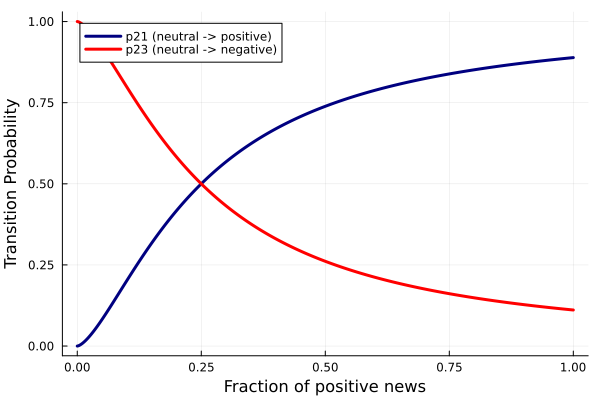

In [5]:
let
    positive_news_fraction = range(0.0,1.0,length = number_of_samples) |> collect;
    tmp_array = Array{Float64,2}(undef, number_of_samples, 3);
    for i ∈ eachindex(positive_news_fraction)
        θ̂ = positive_news_fraction[i];
        tmp_array[i,1] = θ̂
        tmp_array[i,2] = p(θ̂,K,n)
        tmp_array[i,3] = 1 - p(θ̂,K,n)
    end
    plot(tmp_array[:,1], tmp_array[:,2], lw=3, c=:navyblue, label="p21 (neutral -> positive)")
    plot!(tmp_array[:,1], tmp_array[:,3], lw=3, c=:red, label="p23 (neutral -> negative)")
    xlabel!("Fraction of positive news", fontsize=18)
    ylabel!("Transition Probability", fontsize=18)
end

* Now, let's specify the independent values in the transition probability matrix $\mathbf{P}$, i.e., $p_{12}$ and $p_{32}$. For now, pick some constant values for these probabilities such that $p_{12}+p_{32} = 1$:

In [6]:
p21 = p(θ,K,n);
p23 = 1 - p(θ,K,n);
p12 = 0.4; # select your own values
p32 = 0.6; # select your own values

* Finally, put all the entries together into the $\mathbf{P}$ matrix:

In [7]:
P = [
    1 - p12 p12 0.0        ; # state 1
    p21 1 - p23 - p21 p23  ; # state 2
    0.0 p32 1 - p32        ; # state 3
];

### `Check`: Do the rows of the transition matrix $\mathbf{P}$ sum to `1`?
The transition matrix $\mathbf{P}$ describes the probability that we transition from state $i$ (row) to state $j$ (column); thus, given that we must transition to a known future state (including the current state), the rows must sum to `1`. If the state transition matrix does not have this property, it is `invalid.` 
* Let's develop a test to check the transition matrix validity using the `@assert` macro. We'll iterate over the rows using a `for` loop, compute the sum across the column, and compare it to `1`. In this code, we use the `|>` operator, i.e., the [Julia pipe operator](https://docs.julialang.org/en/v1/manual/functions/#Function-composition-and-piping) as a short-cut to pass the data row to the `sum` function

In [8]:
for i ∈ 1:number_of_hidden_states
    sum_value = P[i,:] |> sum;
    @assert(sum_value == 1)
end

In [9]:
P

3×3 Matrix{Float64}:
 0.6       0.4  0.0
 0.881059  0.0  0.118941
 0.0       0.6  0.4

### Compute the stationary distribution $\pi$

Now that we have validated the state transition matrix $\mathbf{P}$, we'll compute the stationary distribution $\pi$ using the recursive `iterate(...)` method. During each call to the `iterate(...)` method, we compute the matrix power of transition matrix $\mathbf{P}$. We continue to call the `iterate(...)` method until we hit one of two possible conditions:

* The `base case` for the recursion occurs when the `counter == maxcount`; at this point, the recursion stops, and the matrix $\mathbf{P}$ is returned
* The recursion also stops when the difference between subsequent powers of the matrix $\mathbf{P}$ is smaller than a specified threshold

In [10]:
π̄ = iterate(P,1,ϵ = 0.000001)

3×3 Matrix{Float64}:
 0.64767  0.294041  0.058289
 0.64767  0.294041  0.058289
 0.64767  0.294041  0.058289

### `Check`: is the $\pi$-distribution a $\text{rank}(\pi) = 1$ matrix?
If the `iterate(...)` function converges, it should return a `rank = ` stationary distribution matrix. Let's check this condition using the `@assert(...)` macro by calling the `rank(...)` function exported by the [LinearAlgebra.jl package](https://github.com/JuliaLang/julia/blob/master/stdlib/LinearAlgebra/src/LinearAlgebra.jl):

In [11]:
@assert(rank(π̄) == 1)

Finally, we can create a [categorical distribution](https://en.wikipedia.org/wiki/Categorical_distribution) using the stationary probability of our Markov chain using the [Distributions.jl package](https://github.com/JuliaStats/Distributions.jl), save this distribution in the variable `d`:

In [12]:
d = Categorical(π̄[1,:]);

## `Task 2`: Setup the Emission Probability Matrix (EPM)
In this model, each state emits a unique signal, thus the Emission Probability Matrix (EPM) will be the `3` $\times$ `3` identity matrix $\mathbf{I}$:

In [13]:
EPM = [
    1.0 0.0 0.0 ; # state 1
    0.0 1.0 0.0 ; # state 2
    0.0 0.0 1.0 ; # state 3
];

Populate the `emission_probability_dict,` which holds a [categorical distribution](https://en.wikipedia.org/wiki/Categorical_distribution) modeling the emission probability for each hidden state $s\in\mathcal{S}$, by building a categorical distribution for each state of the EPM.
* We used the shortcut `foreach (...)` [iteration function](https://docs.julialang.org/en/v1/base/collections/#Base.foreach) to iterate through the hidden states (iteration index `i`) and build a [categorical distribution](https://en.wikipedia.org/wiki/Categorical_distribution) distribution for each emission state.  The shortcut is equivalent to a `for-loop` over the number of hidden states.

In [14]:
emission_probability_dict = Dict{Int,Categorical}()
foreach(i -> emission_probability_dict[i] = Categorical(EPM[i,:]), 1:number_of_hidden_states);

## `Task 3`: Simulate the Hidden Markov Model (HMM)
Finally, now that we have computed (and validated) the stationary distribution and constructed the `emission_probability_dict,` we can sample our HMM model. First, we allocate storage to hold each investor's simulation in the `investor_simulation::Array{Int,2}` array. Then, we simulate the behavior of `number_of_investors` for `number_of_simulation_steps` using a nested `for` loop. For each iteration of the outer `for` loop, we select an investor and:

* We simulate `number_of_simulation_steps` sequential decisions for this investor by sampling the stationary distribution $\pi$, which tells us our hypothetical investor's internal (hidden) state at each stage. From this, we can compute the observed state (decision) by sampling the emission probability. 
* We then stote the decision of each investor `i` at step `j` in the `investor_simulation[i,j]` array

In [15]:
investor_simulation = Array{Int,2}(undef, number_of_investors, number_of_simulation_steps);
for i ∈ 1:number_of_investors
    for j ∈ 1:number_of_simulation_steps
    
        # which state is the mc in?
        hidden_state = rand(d);

        # grab the emission probability model from the emission_probability_dict -
        epd = emission_probability_dict[hidden_state];

        # role for a random ouput -
        investor_simulation[i,j] = rand(epd);
    end
end

In [16]:
investor_simulation

10×480 Matrix{Int64}:
 1  1  2  1  1  2  1  1  1  2  1  3  3  …  1  1  1  1  1  2  2  1  1  1  1  2
 1  1  3  2  1  1  2  1  2  1  1  2  1     2  1  1  1  1  2  1  3  1  1  1  1
 2  1  2  1  2  1  1  1  1  2  2  1  1     1  1  3  1  2  1  1  1  2  1  1  1
 3  3  2  1  1  2  2  1  1  2  2  1  2     1  1  1  1  1  1  1  1  2  2  1  1
 2  1  1  1  1  2  1  1  2  1  2  1  1     1  1  1  1  1  2  1  1  1  1  2  1
 1  1  1  1  1  1  2  1  1  1  2  2  3  …  1  1  1  1  1  1  1  1  2  1  2  1
 1  2  1  2  1  1  2  1  1  2  1  1  1     1  1  2  2  1  1  2  1  1  1  2  2
 1  1  1  3  1  1  1  1  1  1  1  2  1     1  1  1  3  1  3  2  1  1  2  1  1
 2  1  1  1  1  1  2  3  1  2  1  1  2     2  2  1  1  1  2  1  1  1  2  1  2
 2  2  1  1  1  2  1  2  2  2  2  2  1     1  2  2  1  2  2  1  1  1  1  1  1

In [17]:
test_value = 1;
investor_index = 4;
N₊ = 0;
for j ∈ 1:number_of_simulation_steps
    value = investor_simulation[investor_index,j];
      if (value == test_value)
        N₊ += 1
    end
end
probability = N₊/number_of_simulation_steps;
println("We observe state (decision) $(test_value) with probability = $(probability) for θ = $(100*θ)% of good news for investor = $(investor_index)")

We observe state (decision) 1 with probability = 0.6645833333333333 for θ = 95.0% of good news for investor = 4
